This model utilizes keras application InceptionResNetV2: https://keras.io/applications/#inceptionresnetv2
With the rest of the code adapted from *1. Standard CNN* model.

The model achieves 68.3% accuracy on test data, which is the top-performing model of all.

In [0]:
#import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image

from warnings import filterwarnings

np.random.seed(101)
filterwarnings('ignore')
sns.set_style('darkgrid')

**Setting data path**

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# copy file to colab directory
import shutil
shutil.copy2("drive/My Drive/ISIC/ISIC_2019_Training_Input.zip", "./")

'./ISIC_2019_Training_Input.zip'

In [0]:
!unzip -q ISIC_2019_Training_Input.zip

In [0]:
# create image path
base_loc = '/content/ISIC_2019_Training_Input'
image_paths = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_loc, '*.jpg'))}


In [0]:
%cd /content/ISIC_2019_Training_Input

/content/ISIC_2019_Training_Input


In [0]:
# merge csv file with image folder
df_skin = pd.read_csv(os.path.join(base_loc, '/content/drive/My Drive/ISIC/full.csv'))
df_skin.head()

image diagnosis  age_approx  ...     lesion_id     sex is_val
0  ISIC_0012756_downsampled       MEL        55.0  ...  MSK4_0010029    male      0
1  ISIC_0012930_downsampled       MEL        70.0  ...  MSK4_0010026  female      0
2  ISIC_0013184_downsampled       MEL        55.0  ...  MSK4_0010029    male      0
3  ISIC_0013232_downsampled       MEL        70.0  ...  MSK4_0010026  female      0
4  ISIC_0013274_downsampled        NV        65.0  ...  MSK4_0010011    male      0

[5 rows x 7 columns]

In [0]:
# create new column with path information of each lesion
df_skin['image_path'] = df_skin['image'].map(image_paths.get)
df_skin.head()

image  ...                                         image_path
0  ISIC_0012756_downsampled  ...  /content/ISIC_2019_Training_Input/ISIC_0012756...
1  ISIC_0012930_downsampled  ...  /content/ISIC_2019_Training_Input/ISIC_0012930...
2  ISIC_0013184_downsampled  ...  /content/ISIC_2019_Training_Input/ISIC_0013184...
3  ISIC_0013232_downsampled  ...  /content/ISIC_2019_Training_Input/ISIC_0013232...
4  ISIC_0013274_downsampled  ...  /content/ISIC_2019_Training_Input/ISIC_0013274...

[5 rows x 8 columns]

In [0]:
# there are 8 target classes
lesion_types = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis-like lesions ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC': 'Squamous cell carcinoma'}
df_skin['type'] = df_skin['diagnosis'].map(lesion_types.get)

# Converting the type to the categorical values
df_skin['type_id'] = pd.Categorical(df_skin['type']).codes

df_skin.head()

image diagnosis  ...              type type_id
0  ISIC_0012756_downsampled       MEL  ...          Melanoma       5
1  ISIC_0012930_downsampled       MEL  ...          Melanoma       5
2  ISIC_0013184_downsampled       MEL  ...          Melanoma       5
3  ISIC_0013232_downsampled       MEL  ...          Melanoma       5
4  ISIC_0013274_downsampled        NV  ...  Melanocytic nevi       4

[5 rows x 10 columns]

In [0]:
# merge the csv file containing the label with the array of images after resizing them to (100,75)
df_skin['skin_image'] = df_skin['image_path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [0]:
df_skin.head()

image  ...                                         skin_image
0  ISIC_0012756_downsampled  ...  [[[131, 122, 125], [147, 144, 153], [156, 151,...
1  ISIC_0012930_downsampled  ...  [[[190, 162, 150], [193, 175, 165], [192, 174,...
2  ISIC_0013184_downsampled  ...  [[[121, 114, 121], [140, 138, 151], [148, 147,...
3  ISIC_0013232_downsampled  ...  [[[166, 125, 95], [166, 127, 94], [166, 141, 1...
4  ISIC_0013274_downsampled  ...  [[[38, 42, 54], [33, 34, 54], [65, 60, 67], [1...

[5 rows x 11 columns]

In [0]:
# set features and target
features = df_skin.drop(columns=['type_id'],axis=1)
target = df_skin['type_id']

In [0]:
df_skin['type_id'].value_counts()

4    12875
5     4522
1     3323
2     2624
0      867
6      628
7      253
3      239
Name: type_id, dtype: int64

**Splitting data in 80/20 ratio**

In [0]:
# using sklearn library to split the training and testing dataset in 80:20 ratio.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 101)
print('The length of training set is {}\nThe length of testing set is {}\nThe ratio is {}'.format(len(X_train), len(X_test), '80/20'))

The length of training set is 20264
The length of testing set is 5067
The ratio is 80/20


**Normalization**

In [0]:
# Put each array of images to its respective list
X_train = np.asarray(X_train['skin_image'].tolist())
X_test = np.asarray(X_test['skin_image'].tolist())
# Normalize each array by calculate normalized z score
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

One Hot Encoding

In [0]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
y_train = to_categorical(y_train, num_classes= 8)
y_test = to_categorical(y_test, num_classes= 8)

In [0]:
y_test[:9]

array([[0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
print(X_train.shape)
print(X_test.shape)

(20264, 75, 100, 3)
(5067, 75, 100, 3)


**Proposed model - InceptionResNetV2**

In [0]:
# import keras library
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
# import keras application: https://keras.io/applications/#inceptionresnetv2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense,Flatten, Input, AveragePooling2D
from keras.optimizers import Adam
from keras.layers.advanced_activations import ReLU, Softmax
from keras.utils import plot_model
from keras.models import load_model

In [0]:
# download InceptionResNetV2 application
# set up the CNN network
# input shape corresponds to input matrix size
# include_top means whether to include the fully-connected layer at the top of the network. False enables pooling mode for feature extraction.
# average pooling is used
model = InceptionResNetV2(weights='imagenet', input_shape=(75, 100, 3), include_top=False, pooling="avg")














219062272/219055592 [==============================] - 17s 0us/step


In [0]:
model_output = model.output
#final layer is condensed to a 1D vector with length 8 
# and softmax activation function is used
output = Dense(8, activation='softmax')(model_output)
# Now the stem model is combined with the last layer
# The input is the same as before, but for the output an additional Dense layer was added
model = Model(inputs=model.input, outputs=output)

In [0]:
# To compile to model:
# Adam optimizer is used
# Since one-hot-ecoded vectors are used, the categorical cross entropy is used as loss and the metric is set to be top-1 accuracy
model.compile(Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# For each episode the input data is shuffled to create a different order for the inputs
# Batch size is set to be 32 meaning that there are 32 samples fed into the model per gradient update.
# 50 epochs mean that the model will be trained and iterated on the dataset for 50 times.
mod = model.fit(x = X_train, y = y_train, batch_size=32, shuffle=True, epochs= 50)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
20264/20264 [==============================] - 405s 20ms/step - loss: 1.3882 - acc: 0.6121
Epoch 2/50
20264/20264 [==============================] - 341s 17ms/step - loss: 1.3139 - acc: 0.6300
Epoch 3/50
20264/20264 [==============================] - 342s 17ms/step - loss: 1.2823 - acc: 0.6338
Epoch 4/50
20264/20264 [==============================] - 343s 17ms/step - loss: 1.2816 - acc: 0.6326
Epoch 5/50
20264/20264 [==============================] - 344s 17ms/step - loss: 1.3652 - acc: 0.6325
Epoch 6/50
20264/20264 [==============================] - 344s 17ms/step - loss: 1.3285 - acc: 0.6531
Epoch 7/50
20264/20264 [==============================] - 344s 17ms/step - loss: 1.2596 - acc: 0.6763
Epoch 8/50
20264/20264 [==============================] - 342s 17ms/step - loss: 1.2513 - acc: 0.6777
Epoch 9/50
20264/20264 [==============================] - 340s 17ms/step - loss: 1.174

In [0]:
model.save('skin.cr')

**Evaluation**

In [0]:
# Evaluate the accuracy and loss of the model on test dataset
# https://keras.io/models/model/#evaluate
loss,acc = model.evaluate(X_test, y_test)
print("The accuracy of the model is {:.3f}\nThe loss in the model is {:.3f}".format(acc,loss))

5067/5067 [==============================] - 31s 6ms/step
The accuracy of the model is 0.683
The loss in the model is 1.433


**This model yields the highest accuracy after evaluating on the testing dataset**

So below is the detailed evaluation of individual lesion classification accuracy utilizing confusion matrix and classification report function.

In [0]:
from keras.models import load_model
import itertools
from sklearn.metrics import confusion_matrix, classification_report
model = load_model('skin.cr')

In [0]:
# Function to plot confusion matrix
# Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix_normalized(cm, classes,
                          normalize=True,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.Blues):
    # compute confusion matrix - this function plots normalized confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    # All ticks are shown
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Put respective labels on the plot
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(None)

In [0]:
# this function shows non-normalized confusion matrix
def plot_confusion_matrix_nonnormalized(cm, classes,
                          normalize=False,
                          title='Non-normalized confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid(None)

In [0]:
# Using the model to generate predictions
predictions = model.predict(X_test)
# Predictions are converted to one hot vectors.
y_pred = np.argmax(predictions,axis = 1) 

In [0]:
# Target label is converted to one hot vectors
y_true = np.argmax(y_test,1)

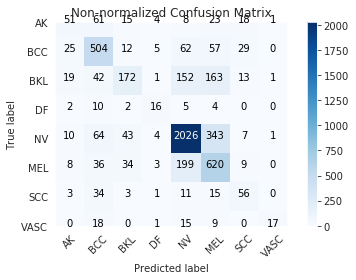

Normalized confusion matrix


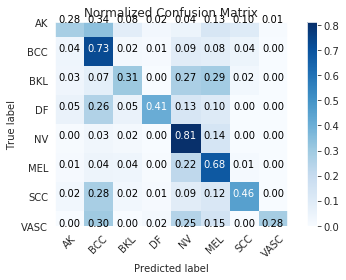

In [0]:
cm = confusion_matrix(y_true, y_pred)
classes = ['AK','BCC','BKL','DF','NV','MEL','SCC','VASC']

# Plot non-normalized confusion matrix
plot_confusion_matrix_nonnormalized(cm, classes)
plt.show()

# Plot normalized confusion matrix
plot_confusion_matrix_normalized(cm, classes)
plt.show()

In [0]:
# Generate classification report to evaluate the model
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

          AK       0.43      0.28      0.34       181
         BCC       0.66      0.73      0.69       694
         BKL       0.61      0.31      0.41       563
          DF       0.46      0.41      0.43        39
          NV       0.82      0.81      0.81      2498
         MEL       0.50      0.68      0.58       909
         SCC       0.42      0.46      0.44       123
        VASC       0.85      0.28      0.42        60

    accuracy                           0.68      5067
   macro avg       0.59      0.49      0.52      5067
weighted avg       0.69      0.68      0.68      5067



- Precision: the ability of a classiifer not to label an 
instance positive that is actually negative. Aka for all instances classified positive, what percent was correct?
- Recall: the ability of a classifier to find all positive instances. Aka for all instances that were actually positive, what percent was classified correctly?
- f1-score: a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0.
- Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

**Case specific evaluation**

Further evaluation is conducted on the binary classification performance of the model. 

Class 1 (basal cell carcinoma), 5 (melanoma) and 6 (squamous cell carcinoma) are cancerous, where class 5 (melanoma) is especially dangerous. 

Therefore, one metric will calculate the performance in distinguishing all forms of cancer from the rest; and the second metric will evaluate the distinction between melanoma from the rest 7 lesions.

The code for this evaluation method is adapted from https://github.com/pegahbyte/deep_learning_image_classification/blob/master/SkinCancerClassification_Project.ipynb

In [0]:
def cancer_detection(model, threshold=0.5):
    '''This function returns the confusion matrix for
    binary cancer detection for a given model and threshold'''
    
    # Define target 1,5 and 6 as dangerous cancer lesions
    # and the other 5 groups as benign
    y_true=[1 if np.argmax(y_test[i]) in [1,5,6] else 0 for i in range(len(y_test))]
    # Predict the values from the test dataset
    y_pred = model.predict(X_test)
    y_pred=[1 if y_pred[i][1]+y_pred[i][5]+y_pred[i][6] > threshold else 0 for i in range(len(y_test))]
    confusion_mtrx=confusion_matrix(y_true,y_pred)
    return(confusion_mtrx)  

def melanoma_detection(model, threshold=0.5):
    '''This function returns the confusion matrix for
    binary melanom detection for a given model and threshold'''
    # Define target 5 as melanoma lesions
    # and the other 7 groups as non-melanoma lesions
    y_true=[1 if np.argmax(y_test[i]) in [5] else 0 for i in range(len(y_test))]
    # Predict the values from the test dataset
    y_pred = model.predict(X_test)
    y_pred=[1 if y_pred[i][5] > threshold else 0 for i in range(len(y_test))]
    confusion_mtrx=confusion_matrix(y_true,y_pred)
    return(confusion_mtrx)

Cancer detection

In [0]:
# generate cancer detection confusion matrix
model_cd = cancer_detection(model)
print(model_cd)
# calculate binary accuracy, false positive rate and false negative rate.
acccd=(model_cd[0,0]+model_cd[1,1])/(sum(sum(model_cd)))
fncd=model_cd[1,0]/sum(model_cd)[1]
fpcd=model_cd[0,1]/sum(model_cd)[0]
print("For the model, the cancer binary-accuracy is", acccd, "\nThe false positive rate is", fpcd,"and the false negative rate is",
     fncd)

[[2569  772]
 [ 366 1360]]
For the model, the cancer binary-accuracy is 0.7754095125320702 
The false positive rate is 0.26303236797274276 and the false negative rate is 0.17166979362101314


Melanoma detection

In [0]:
# generate melanoma detection confusion matrix
model_md = melanoma_detection(model)
print(model_md)
# calculate binary accuracy, false positive rate and false negative rate.
accmd=(model_md[0,0]+model_md[1,1])/(sum(sum(model_md)))
fnmd=model_md[1,0]/sum(model_md)[1]
fpmd=model_md[0,1]/sum(model_md)[0]
print("For the model, the melanoma binary-accuracy is", accmd, "\nThe false positive rate is", fpmd,"and the false negative rate is",
     fnmd)

[[3564  594]
 [ 295  614]]
For the model, the melanoma binary-accuracy is 0.8245510163805013 
The false positive rate is 0.153925887535631 and the false negative rate is 0.24420529801324503


**Below evaluation is not reflected in the report.**
It is left in the code just for your interest.

**Adaptive threshold**

Changing the threshold for cancer detection and see its effects.

In [0]:
thresholds=np.arange(0, 1, 0.05)
resultsFN=[]
resultsFP=[]
costs=[]
for t in thresholds:
    results=cancer_detection(model, t)
    resultsFN.append(results[1,0])
    resultsFP.append(results[0,1])

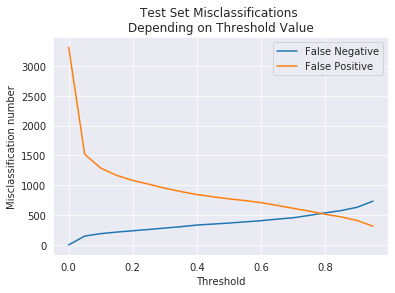

In [0]:
# plot misclassification number against threshold value
plt.plot(thresholds,resultsFN, label="False Negative")
plt.plot(thresholds,resultsFP, label="False Positive")
plt.xlabel('Threshold')
plt.ylabel('Misclassification number')
plt.legend()
plt.title("Test Set Misclassifications \nDepending on Threshold Value");

<function matplotlib.pyplot.imshow>

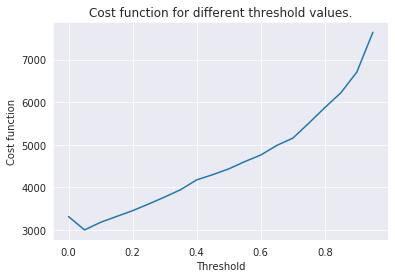

In [0]:
def costs(fn, fp, costFP=1, costFN=10):
    '''Calculates the "cost" of misclassification errors'''
    cost=[fn[i]*costFN+costFP*fp[i] for i in range(len(fn))]
    return(cost)

costs=costs(resultsFN,resultsFP)
plt.plot(thresholds,costs, label="Costs") 
plt.title("Cost function for different threshold values.")
plt.xlabel('Threshold')
plt.ylabel('Cost function')
plt.imshow

**Visualizing curves**

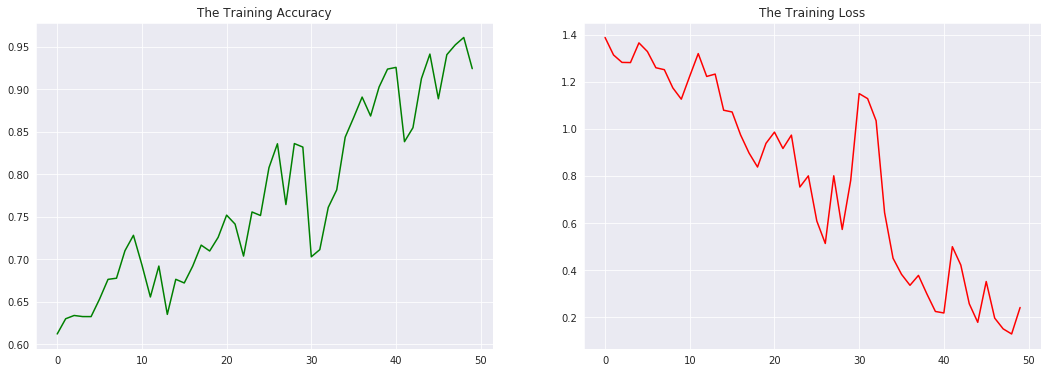

In [0]:
# Visualize the change in training accuracy and loss in the 50 epochs
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(mod.history['acc'], color = 'green')
plt.title('The Training Accuracy')
plt.subplot(1,2,2)
plt.plot(mod.history['loss'], color = 'red')
plt.title('The Training Loss')
plt.show()

In [0]:
plot_model(model, to_file='InceptionResnetv2_model_plot.png', show_shapes=True, show_layer_names=True)